## Predict Risk of Stroke
In this section, the word2vec is used to predict risk of stroke.

### 1. Split train and test data
To test a model, the data are first separated into train and test data. The train data are used for training and cross-validation for each model. The test data are used to evaluate the final performance of each model.

In [1]:
# split train and test data
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import re
%matplotlib inline
matplotlib.style.use('ggplot')

train_val_data = pd.read_csv('stroke_his_info.csv')

# combine history information
X = train_val_data['HISTORY INFO'].values
# get a list of y values
labels = train_val_data['STROKE_LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20,\
                                                    random_state = 42)

### 2. Natural language processing text notes
Because the data are texts, they have to be transformed before applying for a model. To do that, the text notes are first processed with word2vec, and then transformed with term frequency–inverse document frequency with TfidfVectorizer.

In [2]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def tokenizer(text):
    stemmed = []
    text = re.sub('[^a-zA-Z0-9]+', ' ', text)
    text = re.sub('[ ]+', ' ', text)
    text.strip()
    words = text.split()
    for item in words:
        stemmed.append(stemmer.stem(item))   
    return ' '.join(stemmed)

In [3]:
X_train = [tokenizer(s) for s in X_train]
X_train_split = [s.split() for s in X_train]
X_test = [tokenizer(s) for s in X_test]
X_test_split = [s.split() for s in X_test]

In [4]:
import gensim
# train word2vec on the history info
model = gensim.models.Word2Vec(X_train, min_count=10)
w2v = dict(zip(model.index2word, model.syn0))

In [5]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [6]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [7]:
from sklearn.model_selection import GridSearchCV
def search_best_params(clf, params, X, y):
    '''
    this method searchs the best parameters for a model
    '''
    model = GridSearchCV(clf, params, cv = 5, n_jobs =1, scoring = 'recall_macro')
    model.fit(X, y)
    best_parameter = model.best_params_
    return best_parameter 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
# tranformation word2vec with tfidf
tfidf = TfidfEmbeddingVectorizer(w2v)
tfidf.fit(X_train, y_train)
X_train_tfidf = tfidf.transform(X_train)
y_train_t = [1 if s == 'Stroke' else 0 for s in y_train]

In [9]:
# optiomization for linear support vector (SVM)
import time
svc_clf = LinearSVC(random_state = 42)
svc_params = {'tol' : np.logspace(-8, -3, 5),
                     'C' : np.logspace(-3, 3, 6),
                     'max_iter' : [50, 100, 200, 500, 1000],
                     'loss' : ['hinge', 'squared_hinge']} 
best_param_svc = search_best_params(svc_clf, svc_params, X_train_tfidf, y_train_t)   
print best_param_svc
t0 = time.time()
svc_clf_best = LinearSVC(random_state=42, **best_param_svc)
svc_clf_best.fit(X_train_tfidf, y_train_t)
X_test_tfidf = tfidf.transform(X_test)
pred_svc = svc_clf_best.predict(X_test_tfidf)
t1 = time.time()

{'loss': 'squared_hinge', 'C': 63.0957344480193, 'max_iter': 1000, 'tol': 1e-08}


In [10]:
# optimization for Logistic regression
lr_clf = LogisticRegression(random_state = 42)
lr_params = {'tol' : np.logspace(-8, -3, 5),
                     'C' : np.logspace(-3, 3, 6),
                    'penalty': ['l1', 'l2']} 
best_param_lr = search_best_params(svc_clf, svc_params, X_train_tfidf, y_train_t)   
print best_param_lr
t2 = time.time()
lr_clf_best = LinearSVC(random_state=42, **best_param_lr)
lr_clf_best.fit(X_train_tfidf, y_train_t)
pred_lr = lr_clf_best.predict(X_test_tfidf)
t3 = time.time()

{'loss': 'squared_hinge', 'C': 63.0957344480193, 'max_iter': 1000, 'tol': 1e-08}


                          accu_score  precision  recall_score        time
LogisticRegression (opt)   65.562914  65.876881      65.53395    2.980635
SVM(opt)                   65.562914  65.876881      65.53395  228.526824


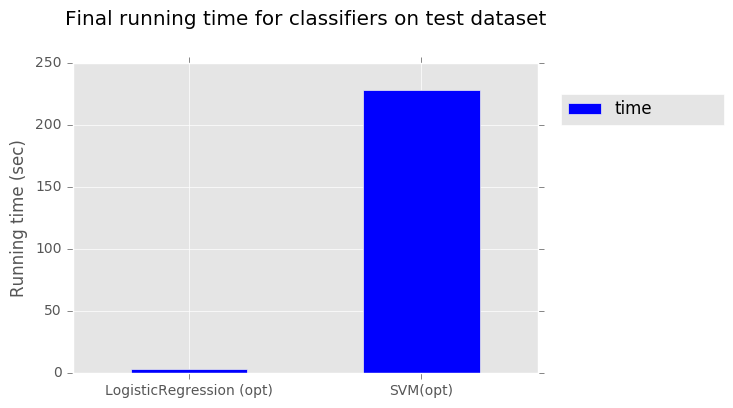

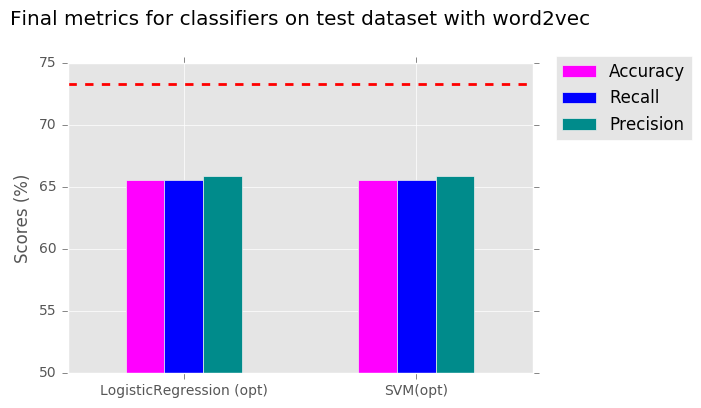

In [25]:
from sklearn.metrics import recall_score, accuracy_score, precision_score
y_test_t = [1 if s == 'Stroke' else 0 for s in y_test]
preds = [pred_lr, pred_svc]
times = [t1 - t0, t2 - t1]
clfs = ['LogisticRegression (opt)', 'SVM(opt)']
recall_scores = [recall_score(y_test_t, pred, average = 'macro')*100 for pred in preds]
precision_scores = [precision_score(y_test_t, pred, average = 'macro')*100 for pred in preds]
accuracy_scores = [accuracy_score(y_test_t, pred)*100 for pred in preds]

df = pd.DataFrame({'time':times, 'accu_score': accuracy_scores, 'recall_score': recall_scores, 
                   'precision': precision_scores})
df.index = clfs

print df
# plot the time graph
plt.Figure(figsize = (15,8))
df[['time']].plot(kind = 'bar', color = ['b'], rot = 0)
plt.legend(['time'], bbox_to_anchor=(1.05, .8, 0.35, 0),loc=3, mode="expand",
                   borderaxespad=0.)
plt.ylabel('Running time (sec)')
plt.title('Final running time for classifiers on test dataset', y = 1.1)
# plot the final metrics graph
plt.Figure(figsize = (10,8))
df_1 = df[['accu_score', 'recall_score', 'precision']]
df_1.plot(kind = 'bar', color = ['magenta', 'blue', 'darkcyan'], rot = 0)
plt.ylim([50, 75])
plt.legend(['Accuracy', 'Recall', 'Precision'], bbox_to_anchor=(1.05, 0.75, 0.75, 0),loc=3,
                   borderaxespad=0.)
plt.axhline(y = 73.3, color = 'red', linestyle='dashed', linewidth=2)
plt.ylabel('Scores (%)')
plt.title('Final metrics for classifiers on test dataset with word2vec', y = 1.1)